In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from tqdm import tqdm
from pathlib import Path

In [8]:
def load_data(input_file):
    """
    Load waveform data from CSV.
    Expects waveform columns to start with 't'.
    """
    df = pd.read_csv(input_file)
    waveforms = df[[c for c in df.columns if c.startswith("t")]].values
    return df, waveforms

In [12]:
# Define the base directory
BASE_DIR = Path("../").resolve()  # from base/notebooks to base/
input_file = BASE_DIR / "data/run0006/layer1_x3_y1.csv"
print(input_file)
df, waveforms = load_data(input_file)
print(f"Loaded {len(waveforms)} waveforms with shape {waveforms.shape}")

/home/wimmer/projects/LISA/MLwaves/data/run0006/layer1_x3_y1.csv
Loaded 9065 waveforms with shape (9065, 400)


In [37]:
from scipy.optimize import curve_fit
def gaussian(x, A, mean, sigma):
    return A * np.exp(-(x - mean)**2 / (2 * sigma**2))

def fit_energy_spectrum(energies, bins=200, expand_window=False):
    counts, edges = np.histogram(energies, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2

    rms = np.std(energies)
    peak = centers[np.argmax(counts)]
    window = 2 * rms if expand_window else 1 * rms
    mask = (centers > peak - window) & (centers < peak + window)
    x_fit = centers[mask]
    y_fit = counts[mask]
    
    try:
        A0 = max(y_fit)
        sigma0 = rms
        popt, _ = curve_fit(
            gaussian,
            x_fit,
            y_fit,
            p0=[A0, peak, sigma0],
            bounds=([0, 0, 0], [np.inf, np.inf, np.inf])  # force sigma > 0
        )
        A, mean, sigma = popt
        resolution = sigma / mean * 100
        return centers, counts, mean, sigma, resolution
    except Exception as e:
        print(f"Fit failed: {e}")
        return centers, counts, None, None, None

In [38]:
def align_and_normalize(waveform, align_range=(80, 150), align_to=100):
    """
    Align waveform to a common pulse position and normalize amplitude.
    """
    idx_min = np.argmin(waveform[align_range[0]:align_range[1]]) + align_range[0]
    shift = align_to - idx_min
    shifted = np.roll(waveform, shift)

    baseline = np.mean(shifted[20:80])
    centered = shifted - baseline
    normalized = centered / np.max(np.abs(centered))

    return normalized


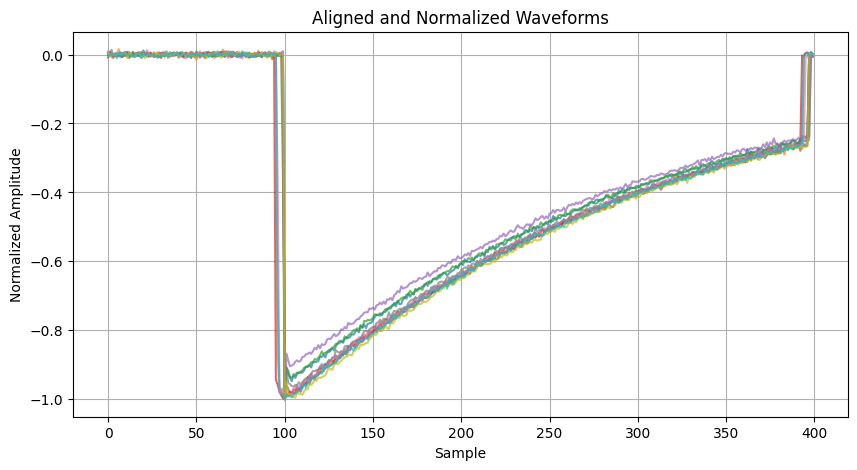

In [39]:
plt.figure(figsize=(10, 5))
for i in range(10):
    aligned = align_and_normalize(waveforms[i])
    plt.plot(aligned, alpha=0.7)

plt.title("Aligned and Normalized Waveforms")
plt.xlabel("Sample")
plt.ylabel("Normalized Amplitude")
plt.grid(True)
plt.show()

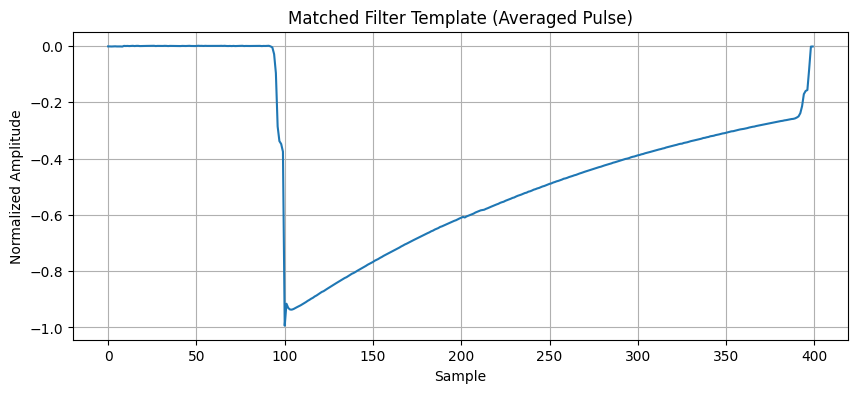

In [40]:
N_template = 200  # number of waveforms to use
template_stack = np.array([align_and_normalize(wf) for wf in waveforms[:N_template]])
avg_template = np.mean(template_stack, axis=0)

plt.figure(figsize=(10, 4))
plt.plot(avg_template)
plt.title("Matched Filter Template (Averaged Pulse)")
plt.xlabel("Sample")
plt.ylabel("Normalized Amplitude")
plt.grid(True)
plt.show()

In [41]:
def align_by_slope(waveform, align_range=(80, 150), align_to=100):
    """
    Align waveform based on maximum negative slope (falling edge of pulse).
    """
    baseline = np.mean(waveform[20:80])
    centered = waveform - baseline

    # Find steepest negative slope (most negative diff)
    derivative = np.diff(centered)
    slope_idx = np.argmin(derivative[align_range[0]:align_range[1]]) + align_range[0]

    shift = align_to - slope_idx
    aligned = np.roll(centered, shift)

    # Normalize by pulse height (first drop, not overshoot)
    min_val = np.min(aligned[align_to+10:align_to + 30])
    normalized = aligned / abs(min_val)

    return normalized

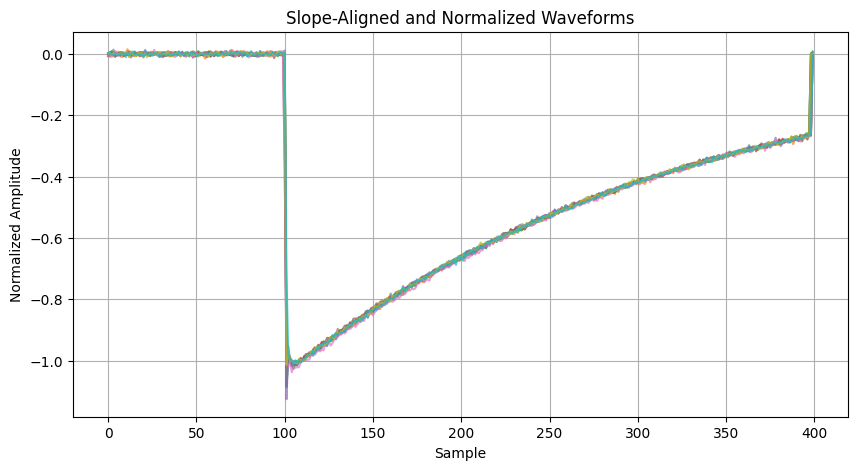

In [42]:
plt.figure(figsize=(10, 5))
for i in range(10):
    aligned = align_by_slope(waveforms[i])
    plt.plot(aligned, alpha=0.7)

plt.title("Slope-Aligned and Normalized Waveforms")
plt.xlabel("Sample")
plt.ylabel("Normalized Amplitude")
plt.grid(True)
plt.show()

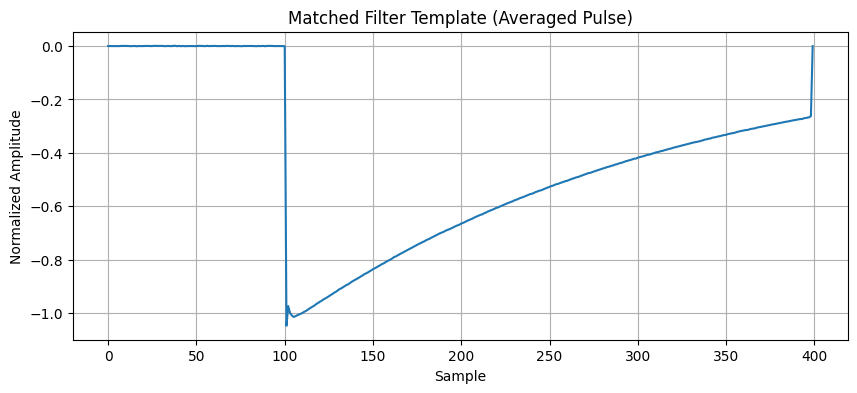

In [59]:
N_template = 200  # number of waveforms to use
template_stack = np.array([align_by_slope(wf) for wf in waveforms[:N_template]])
avg_template = np.median(template_stack, axis=0)

plt.figure(figsize=(10, 4))
plt.plot(avg_template)
plt.title("Matched Filter Template (Averaged Pulse)")
plt.xlabel("Sample")
plt.ylabel("Normalized Amplitude")
plt.grid(True)
plt.show()


In [60]:
from scipy.signal import correlate

def matched_filter_energy(waveform, template):
    # Baseline subtract waveform
    wf = waveform - np.mean(waveform[20:80])

    # Normalize template (already median-averaged)
    template = template - np.mean(template)
    template = template / np.linalg.norm(template)

    # Cross-correlate
    corr = correlate(wf, template, mode="valid")

    # Energy estimate = max correlation
    return np.max(corr)


In [61]:
matched_energies = []

for wf in tqdm(waveforms, desc="Matched filter energy"):
    energy = matched_filter_energy(wf, avg_template)
    matched_energies.append(energy)

df["matched_energy"] = matched_energies

Matched filter energy: 100%|█████████████| 9065/9065 [00:00<00:00, 13166.93it/s]


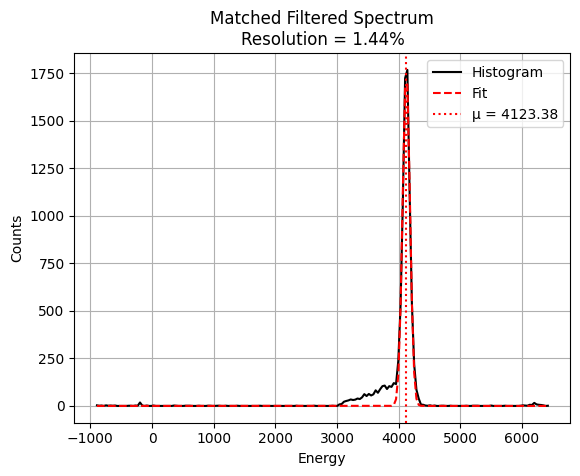

In [62]:
energies = df["matched_energy"].dropna()
centers, counts, mean, sigma, res = fit_energy_spectrum(energies)

plt.plot(centers, counts, label="Histogram", color="black")
if mean:
    plt.plot(centers, gaussian(centers, max(counts), mean, sigma), 'r--', label="Fit")
    plt.axvline(mean, color='red', linestyle=':', label=f"μ = {mean:.2f}")
    plt.title(f"Matched Filtered Spectrum\nResolution = {res:.2f}%")
else:
    plt.title("Fit failed")

plt.xlabel("Energy")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.show()